In [1]:
# import required packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import geopandas as gpd
import rasterio as rio
import datetime as dt
import pandas as pd
import sys
import seaborn as sns
from geogif import gif
import os

In [2]:
# ds_list = []
# for ds_path in glob.glob('./data/*.nc'):
#     ds = xr.open_dataset(ds_path)
#     ds = ds.drop_vars('band')
#     ds = ds.drop('s1')
#     ds = ds.transpose('time', 'y', 'x')
#     if ds_list:
#         ds = ds.rio.reproject_match(ds_list[0])
#     ds_list.append(ds)
    
# ds = xr.concat(ds_list, dim='time')

# ds = ds.sortby('time')

# # reproject dataset to utm zone
# crs = ds.rio.estimate_utm_crs()
# ds = ds.rio.reproject(crs)

# # open aoi geojson as geopandas dataframe and reproject
# aoi_fn = './erb_pumphouse_wgs.geojson'
# aoi_gdf = gpd.read_file(aoi_fn).to_crs(crs)

# # clip dataset to aoi
# ds = ds.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=True)

# # exclude orbit without full coverage
# ds = ds.where(ds.relative_orbit!=129.0, drop=True)

In [3]:
# ds.to_netcdf('./data/sd_2016-2022_east-riverv2.nc')

In [4]:
ds = xr.open_dataset('./data/sd_2016-2022_east-riverv2.nc')

In [5]:
crs = ds.rio.estimate_utm_crs()

# open aoi geojson as geopandas dataframe and reproject
aoi_fn = './erb_pumphouse_wgs.geojson'
aoi_gdf = gpd.read_file(aoi_fn).to_crs(crs)

# clip dataset to aoi
ds = ds.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=True)

In [6]:
# alt loading snotel for when api is down
butte = pd.read_csv('butte_2015-2023.csv')
butte['date'] = pd.to_datetime(butte['date'])
butte['sd_m'] = butte['sd_inches']*0.0254
schofield = pd.read_csv('schofield_2015-2023.csv')
schofield['date'] = pd.to_datetime(schofield['date'])
schofield['sd_m'] = schofield['sd_inches']*0.0254

In [8]:
dir_path = 'lidar'
aso_glob = glob(f'{dir_path}/ASO*.tif')
date_list = pd.to_datetime([os.path.split(path)[-1][18:-4] for path in aso_glob])

da_list = []
for i, path in enumerate(aso_glob):
    da = xr.open_dataset(path).squeeze()
    da = da.rio.reproject_match(ds)
    da = da.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=True)
    da = da.assign_coords({'time':('time', [date_list[i]])})
    da_list.append(da)
    
aso_ds = xr.concat(da_list, dim='time')

In [9]:
# load in discharge data (m^3/s)
q_df = pd.read_csv('./All_RF_Wide.csv')[['dateTime', 'Q.PH_ISCO']]
q_df['dateTime'] = pd.to_datetime(q_df['dateTime'])
q_df['water_year'] = q_df.dateTime.dt.year.where(q_df.dateTime.dt.month < 10, q_df.dateTime.dt.year + 1)

In [10]:
# convert discharge data
q_df['m3_perhour'] = q_df['Q.PH_ISCO']*60*60

# accumulate discharge throughout water year
q_df['cum_m3'] = q_df[['water_year', 'm3_perhour']].groupby('water_year').cumsum()

In [11]:
# add water year to ds
ds = ds.assign_coords(water_year = ('time', ds.time.dt.year.where(ds.time.dt.month < 10, ds.time.dt.year + 1).values))

# edit wet snow mask
ds['wet_snow'] = xr.where(ds.snow_depth == 0, 0, ds.wet_snow)

# mask wet snow
ds['dry_snow_depth'] = ds.snow_depth.where(ds.wet_snow < 1)

# interpolate nans through time 
ds['snow_depth_interp'] = ds.dry_snow_depth.interpolate_na(dim='time', method='nearest')

In [12]:
# assume a snow density of 0.3 
w_content = 0.3

ds['total_snow_storage'] = (ds.snow_depth_interp*w_content*float(ds.resolution)**2).sum(dim=['x', 'y'])
ds['depth_diff'] = ds.total_snow_storage.diff('time')
ds['depth_diff_rolling'] = ds.total_snow_storage.rolling(time=2).mean().diff('time')

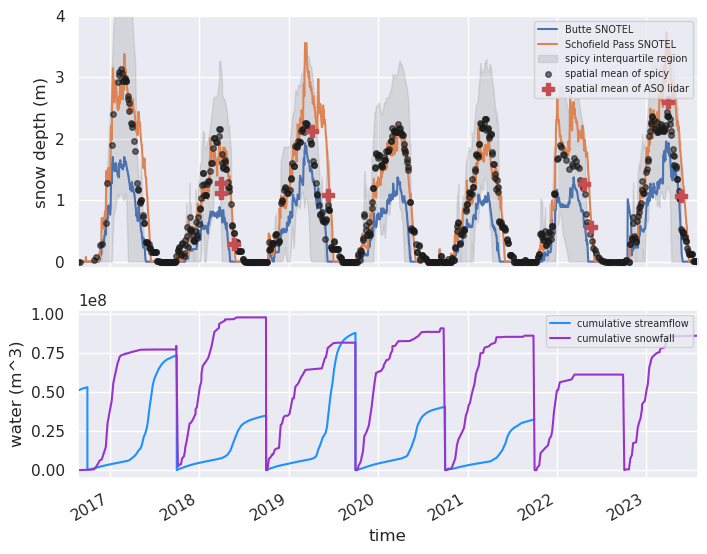

In [13]:
# plot snow depth time series
gridspec = {'height_ratios': [1.5, 1]}

sns.set_theme()
f, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw=gridspec)
ax[0].plot(butte.date, butte.sd_m, label='Butte SNOTEL')
ax[0].plot(schofield.date, schofield.sd_m, label='Schofield Pass SNOTEL')
ax[0].fill_between(ds.snow_depth_interp.quantile(q=0.25, dim=['x', 'y']).dropna(dim='time').time,
                ds.snow_depth_interp.quantile(q=0.25, dim=['x', 'y']).dropna(dim='time').values,
                ds.snow_depth_interp.quantile(q=0.75, dim=['x', 'y']).dropna('time').values,
                alpha=0.2, color='Grey', label='spicy interquartile region')
# for site in sntl_ds.Location:
#     sntl_ds.sel(Location=site).SNWD.plot(label=f'SNOTEL {site.values} snow depth')
ds.snow_depth_interp.mean(dim=['x', 'y']).plot(ax=ax[0], marker='o', linestyle='', alpha=0.6, c='k', markersize=4,
                                        label='spatial mean of spicy')
aso_ds.band_data.mean(dim=['x', 'y']).plot(ax=ax[0], marker='P', linestyle='', alpha=1, c='r', markersize=8,
                                        label='spatial mean of ASO lidar')
ax[0].set_xlim(ds.time[0], ds.time[-1])
ax[0].set_ylim(-0.1, 4)
ax[0].set_ylabel('snow depth (m)')
ax[0].set_xlabel('')
ax[0].legend(fontsize=7, loc = "upper right")
ax[0].set_title('')

ax[1].plot(q_df['dateTime'], q_df['cum_m3'], c='dodgerblue', label='cumulative streamflow')
ds.depth_diff.where(ds.depth_diff >= 0, drop=True).groupby('water_year').cumsum().plot(ax=ax[1], c='darkorchid', label='cumulative snowfall')
ax[1].set_xlim(ds.time[0], ds.time[-1])
ax[1].set_ylabel('water (m^3)')
ax[1].set_title('')
ax[1].legend(fontsize=7, loc = "upper right")

#f.tight_layout()

plt.savefig('./figs/sd_ts.png', dpi=300)

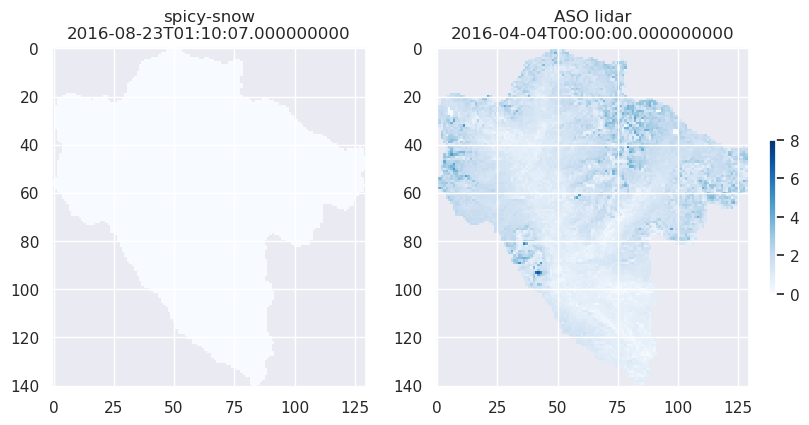

In [18]:
# exclude orbit without full coverage
ds = ds.where(ds.relative_orbit!=129.0, drop=True)

gridspec = {'width_ratios': [1, 1.25]}

f, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw=gridspec)
ax[0].imshow(ds.sel(time=aso_ds.time, method='nearest').isel(time=1).snow_depth, 
             cmap='Blues', vmax=8, interpolation='none')
ax[0].set_aspect('equal')
ax[0].set_title(f'spicy-snow\n{ds.sel(time=aso_ds.time, method="nearest").isel(time=1).time.values}')
im = ax[1].imshow(aso_ds.band_data.isel(time=1), 
             cmap='Blues', vmax=8, interpolation='none')
ax[1].set_aspect('equal')
ax[1].set_title(f'ASO lidar\n{aso_ds.band_data.isel(time=1).time.values}')
f.colorbar(im, ax=ax[1], shrink=0.4)

plt.savefig('./figs/spicy_ASO_201804.png', dpi=300)

In [ ]:
gridspec = {'width_ratios': [1, 1.25]}

f, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw=gridspec)
ax[0].imshow(ds.sel(time=aso_ds.time, method='nearest').isel(time=2).snow_depth, 
             cmap='Blues', vmax=8, interpolation='none')
ax[0].set_aspect('equal')
ax[0].set_title(f'spicy-snow\n{ds.sel(time=aso_ds.time, method="nearest").isel(time=2).time.values}')
im = ax[1].imshow(aso_ds.band_data.isel(time=2), 
             cmap='Blues', vmax=8, interpolation='none')
ax[1].set_aspect('equal')
ax[1].set_title(f'ASO lidar\n{aso_ds.band_data.isel(time=2).time.values}')
f.colorbar(im, ax=ax[1], shrink=0.4)

plt.savefig('./figs/spicy_ASO_201804(2).png', dpi=300)

In [ ]:
gridspec = {'width_ratios': [1, 1.25]}

f, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw=gridspec)
ax[0].imshow(ds.sel(time=aso_ds.time, method='nearest').isel(time=3).snow_depth, 
             cmap='Blues', vmax=8, interpolation='none')
ax[0].set_aspect('equal')
ax[0].set_title(f'spicy-snow\n{ds.sel(time=aso_ds.time, method="nearest").isel(time=3).time.values}')
im = ax[1].imshow(aso_ds.band_data.isel(time=3), 
             cmap='Blues', vmax=8, interpolation='none')
ax[1].set_aspect('equal')
ax[1].set_title(f'ASO lidar\n{aso_ds.band_data.isel(time=3).time.values}')
f.colorbar(im, ax=ax[1], shrink=0.4)

plt.savefig('./figs/spicy_ASO_201805.png', dpi=300)

In [ ]:
gridspec = {'width_ratios': [1, 1.25]}

f, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw=gridspec)
ax[0].imshow(ds.sel(time=aso_ds.time, method='nearest').isel(time=4).snow_depth, 
             cmap='Blues', vmax=8, interpolation='none')
ax[0].set_aspect('equal')
ax[0].set_title(f'spicy-snow\n{ds.sel(time=aso_ds.time, method="nearest").isel(time=4).time.values}')
im = ax[1].imshow(aso_ds.band_data.isel(time=4), 
             cmap='Blues', vmax=8, interpolation='none')
ax[1].set_aspect('equal')
ax[1].set_title(f'ASO lidar\n{aso_ds.band_data.isel(time=4).time.values}')
f.colorbar(im, ax=ax[1], shrink=0.4)

plt.savefig('./figs/spicy_ASO_201904.png', dpi=300)

In [ ]:
gridspec = {'width_ratios': [1, 1.25]}

f, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw=gridspec)
ax[0].imshow(ds.sel(time=aso_ds.time, method='nearest').isel(time=5).snow_depth, 
             cmap='Blues', vmax=8, interpolation='none')
ax[0].set_aspect('equal')
ax[0].set_title(f'spicy-snow\n{ds.sel(time=aso_ds.time, method="nearest").isel(time=5).time.values}')
im = ax[1].imshow(aso_ds.band_data.isel(time=5), 
             cmap='Blues', vmax=8, interpolation='none')
ax[1].set_aspect('equal')
ax[1].set_title(f'ASO lidar\n{aso_ds.band_data.isel(time=5).time.values}')
f.colorbar(im, ax=ax[1], shrink=0.4)

plt.savefig('./figs/spicy_ASO_201906.png', dpi=300)

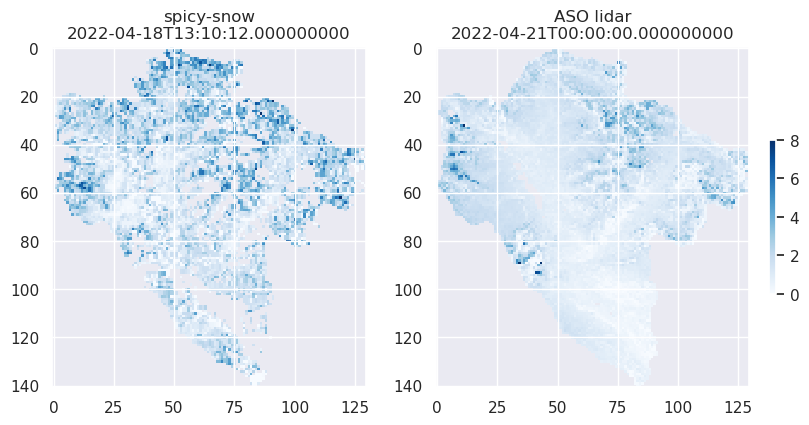

In [16]:
gridspec = {'width_ratios': [1, 1.25]}

f, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw=gridspec)
ax[0].imshow(ds.sel(time=aso_ds.time, method='nearest').isel(time=7).snow_depth, 
             cmap='Blues', vmax=8, interpolation='none')
ax[0].set_aspect('equal')
ax[0].set_title(f'spicy-snow\n{ds.sel(time=aso_ds.time, method="nearest").isel(time=7).time.values}')
im = ax[1].imshow(aso_ds.band_data.isel(time=7), 
             cmap='Blues', vmax=8, interpolation='none')
ax[1].set_aspect('equal')
ax[1].set_title(f'ASO lidar\n{aso_ds.band_data.isel(time=7).time.values}')
f.colorbar(im, ax=ax[1], shrink=0.4)

plt.savefig('./figs/spicy_ASO_202204.png', dpi=300)

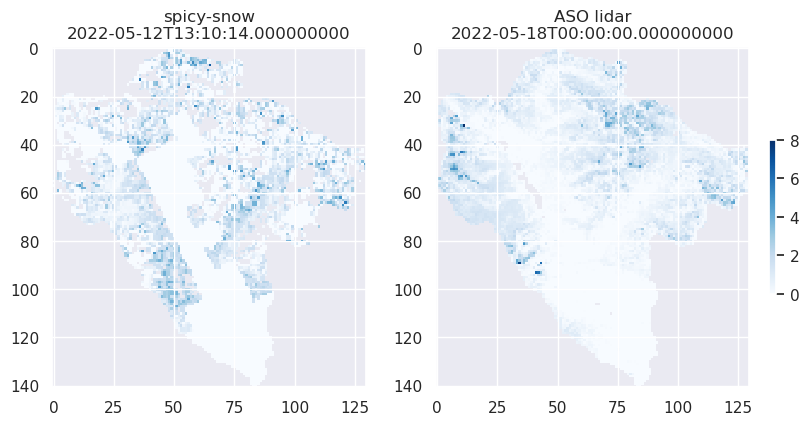

In [20]:
gridspec = {'width_ratios': [1, 1.25]}

f, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw=gridspec)
ax[0].imshow(ds.sel(time=aso_ds.time, method='nearest').isel(time=8).snow_depth, 
             cmap='Blues', vmax=8, interpolation='none')
ax[0].set_aspect('equal')
ax[0].set_title(f'spicy-snow\n{ds.sel(time=aso_ds.time, method="nearest").isel(time=8).time.values}')
im = ax[1].imshow(aso_ds.band_data.isel(time=8), 
             cmap='Blues', vmax=8, interpolation='none')
ax[1].set_aspect('equal')
ax[1].set_title(f'ASO lidar\n{aso_ds.band_data.isel(time=8).time.values}')
f.colorbar(im, ax=ax[1], shrink=0.4)

plt.savefig('./figs/spicy_ASO_202205.png', dpi=300)

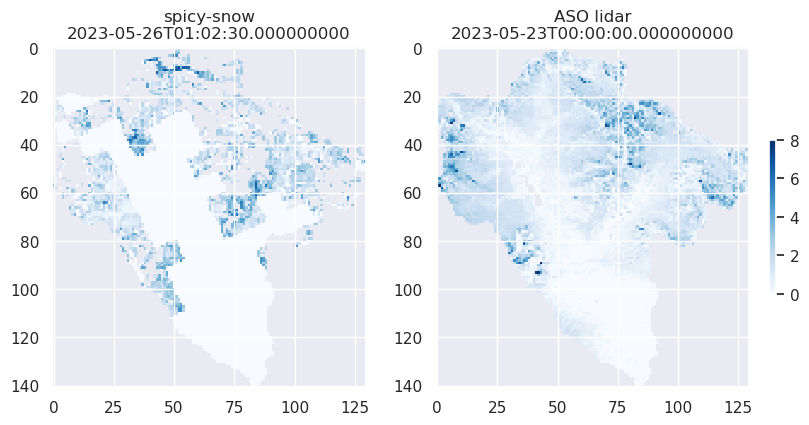

In [23]:
gridspec = {'width_ratios': [1, 1.25]}

f, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw=gridspec)
ax[0].imshow(ds.sel(time=aso_ds.time, method='nearest').isel(time=9).snow_depth, 
             cmap='Blues', vmax=8, interpolation='none')
ax[0].set_aspect('equal')
ax[0].set_title(f'spicy-snow\n{ds.sel(time=aso_ds.time, method="nearest").isel(time=9).time.values}')
im = ax[1].imshow(aso_ds.band_data.isel(time=9), 
             cmap='Blues', vmax=8, interpolation='none')
ax[1].set_aspect('equal')
ax[1].set_title(f'ASO lidar\n{aso_ds.band_data.isel(time=9).time.values}')
f.colorbar(im, ax=ax[1], shrink=0.4)

plt.savefig('./figs/spicy_ASO_202305.png', dpi=300)

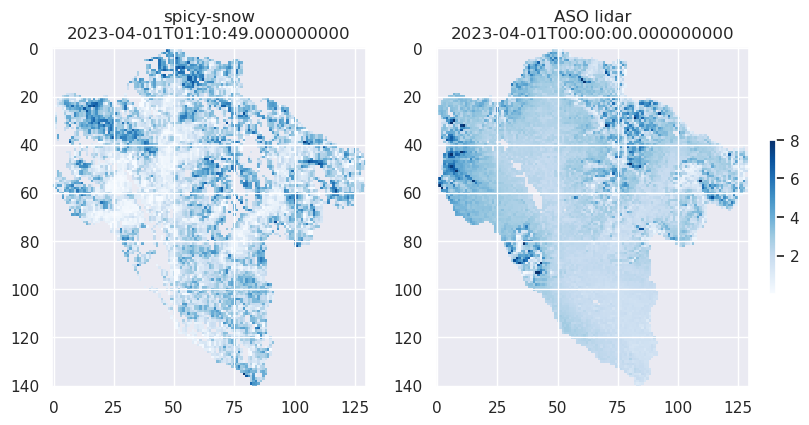

In [28]:
gridspec = {'width_ratios': [1, 1.25]}

f, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw=gridspec)
ax[0].imshow(ds.sel(time=aso_ds.time, method='nearest').isel(time=0).snow_depth, 
             cmap='Blues', vmax=8, interpolation='none')
ax[0].set_aspect('equal')
ax[0].set_title(f'spicy-snow\n{ds.sel(time=aso_ds.time, method="nearest").isel(time=0).time.values}')
im = ax[1].imshow(aso_ds.band_data.isel(time=0), 
             cmap='Blues', vmax=8, interpolation='none')
ax[1].set_aspect('equal')
ax[1].set_title(f'ASO lidar\n{aso_ds.band_data.isel(time=0).time.values}')
f.colorbar(im, ax=ax[1], shrink=0.4)

plt.savefig('./figs/spicy_ASO_202304.png', dpi=300)

In [ ]:
ds.snow_depth_interp.isel(time=14).plot(cmap='Blues')

In [ ]:
gif(ds.snow_depth_interp, fps=4, cmap='Blues', vmin=0, vmax=7, date_position='ll', to='./sd_interp.gif')